In [1]:
!pip install scanpy scikit-misc --quiet

In [2]:
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
print('Scanpy version:', sc.__version__)

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

Scanpy version: 1.9.6


/tmp/ipykernel_2729/1644390834.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
# !pip install scperturb --upgrade
# from scperturb import *

In [4]:
import sys
sys.path.append("..")
%reload_ext autoreload
%autoreload 2
from src.scperturb import *

# Prepare the data

In [5]:
# !wget https://zenodo.org/record/7041849/files/DatlingerBock2021.h5ad
file = '/scratch/peidli/scPerturb/DatlingerBock2021.h5ad'
adata = sc.read_h5ad(file)
adata

AnnData object with n_obs × n_vars = 39194 × 25904
    obs: 'sample', 'cell_line', 'perturbation', 'perturbation_2', 'tissue_type', 'cancer', 'celltype', 'disease', 'organism', 'perturbation_type', 'perturbation_type_2', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [6]:
if 'processed' in adata.uns.keys():
    print('The dataset is already processed. Skipping processing...')
else:
    adata.layers['counts'] = adata.X.copy()

    # basic qc and pp
    sc.pp.filter_cells(adata, min_counts=1000)
    sc.pp.normalize_per_cell(adata)
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.log1p(adata)

    # high class imbalance
    adata = equal_subsampling(adata, 'perturbation', N_min=200)
    sc.pp.filter_genes(adata, min_cells=3)  # sanity cleaning

    # select HVGs
    n_var_max = 2000  # max total features to select
    sc.pp.highly_variable_genes(adata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
    sc.pp.pca(adata, use_highly_variable=True)
    sc.pp.neighbors(adata)

    adata.uns['processed'] = True

# WORKBENCH

In [8]:
['a'] + ['c']

['a', 'c']

# E-distance

In [13]:
# Compute E-distances
estats = edist(adata, obs_key='perturbation', obsm_key='X_pca', dist='sqeuclidean')

100%|██████████| 496/496 [00:00<00:00, 625.12it/s]


In [14]:
# square matrix, all pairs of perturbations get an e-distance
estats.head()

perturbation,control,LAT_2,LCK_2,JUND_2,ZAP70_2,FOS_2,EGR3_2,EGR4_1,PTPN11_2,LAT_1,...,NFAT5_2,EGR2_2,DOK2_2,FOS_1,LCK_1,PTPN6_2,NR4A1_1,ZAP70_1,RUNX2_2,JUN_2
perturbation,,,,,,,,,,,,,,,,,,,,,
control,0.000000,2.817963,2.021977,1.031441,2.754259,0.301189,0.750653,0.350060,1.291844,3.554450,...,0.378877,0.724048,0.747261,1.705717,2.237211,0.701783,0.955657,2.527144,1.041078,1.931288
LAT_2,2.817963,0.000000,0.108023,0.375572,-0.086406,1.287670,0.476955,1.717763,0.747858,0.064079,...,1.491151,0.664894,0.938912,0.216857,0.230611,1.592959,1.099997,0.342951,0.370278,0.195334
LCK_2,2.021977,0.108023,0.000000,0.229973,0.186105,0.999078,0.325879,1.221093,0.250805,0.186737,...,1.279692,0.482461,0.719397,0.029821,-0.001440,0.882495,0.467896,0.055257,0.242149,0.048678
JUND_2,1.031441,0.375572,0.229973,0.000000,0.359794,0.210584,-0.085757,0.478101,0.473056,0.866877,...,0.349776,-0.077186,0.073844,0.165285,0.434723,0.694040,0.558524,0.696989,-0.034427,0.129465
ZAP70_2,2.754259,-0.086406,0.186105,0.359794,0.000000,1.282809,0.468966,1.793397,0.977730,0.266221,...,1.472765,0.533258,0.866270,0.243210,0.365051,1.705474,1.242829,0.495465,0.350968,0.308219


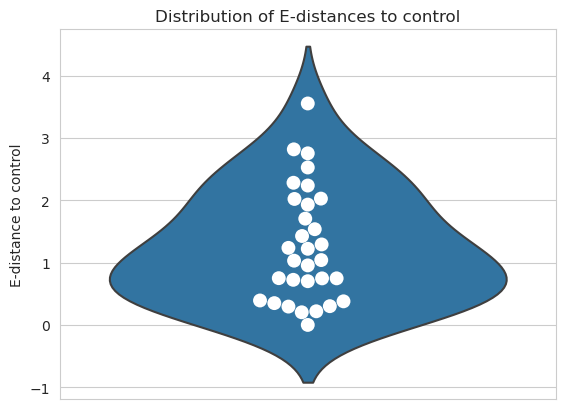

In [15]:
with sns.axes_style('whitegrid'):
    sns.violinplot(data=estats.loc['control'], inner=None)
    sns.swarmplot(data=estats.loc['control'], size=10, color='white')
pl.xticks([0], [''])
pl.ylabel('E-distance to control')
pl.title('Distribution of E-distances to control')
pl.show()

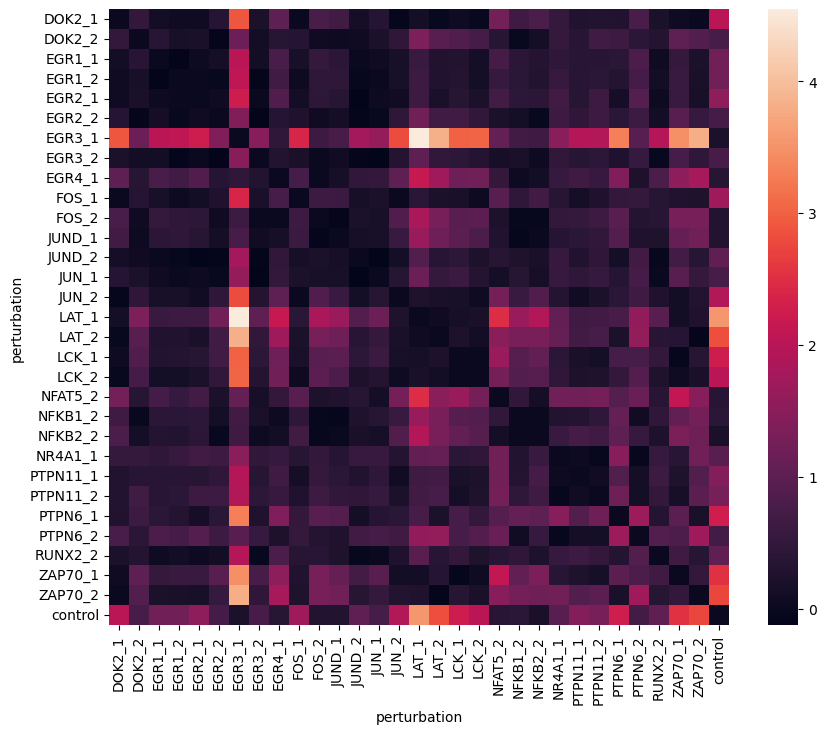

In [16]:
fig, ax = pl.subplots(1,1, figsize=[10,8])
order = estats.sort_index().index
sns.heatmap(estats.loc[order, order])
pl.show()

# E-testing

In [17]:
# e-testing (can be slow)
df = etest(adata, obs_key='perturbation', obsm_key='X_pca', dist='sqeuclidean', control='control', alpha=0.05, runs=1000, n_jobs=-1)

100%|██████████| 1000/1000 [00:07<00:00, 129.30it/s]
/opt/conda/lib/python3.10/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


In [20]:
df.head()

,edist,pvalue,significant,pvalue_adj,significant_adj
DOK2_1,0.000000,1.000,False,1.000000,False
DOK2_2,0.121912,0.045,True,0.450404,False
EGR1_1,0.160344,0.028,True,0.336727,False
EGR1_2,0.133719,0.051,False,0.466426,False
EGR2_1,0.293057,0.002,True,0.041171,True


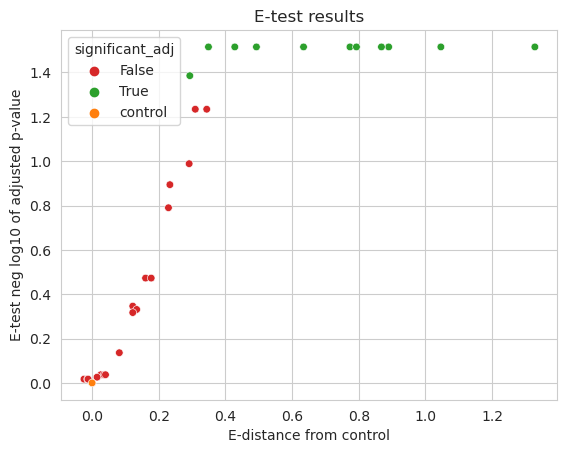

In [21]:
df.loc[df.index=='control', 'significant_adj'] = 'control'
df['neglog10_pvalue_adj'] = -np.log10(df['pvalue_adj'])
with sns.axes_style('whitegrid'):
    sns.scatterplot(data=df, y='neglog10_pvalue_adj', x='edist', hue='significant_adj', palette={True: 'tab:green', False: 'tab:red', 'control': 'tab:orange'}, s=30)
pl.title('E-test results')
pl.xlabel('E-distance from control')
pl.ylabel('E-test neg log10 of adjusted p-value')
pl.show()

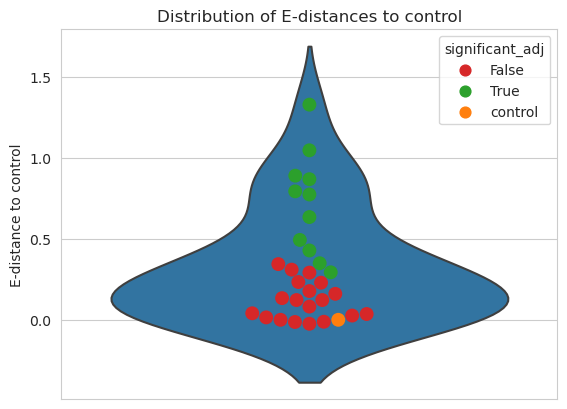

In [22]:
with sns.axes_style('whitegrid'):
    sns.violinplot(data=df, y='edist', inner=None)
    sns.swarmplot(data=df, x=[0]*len(df), y='edist', size=10, hue='significant_adj', dodge=False, palette={True: 'tab:green', False: 'tab:red', 'control': 'tab:orange'})
pl.xticks([0], [''])
pl.ylabel('E-distance to control')
pl.title('Distribution of E-distances to control')
pl.show()